In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow import keras
import pandas as pd

In [4]:
BATCH_SIZE = 128
IMAGE_SIZE = 100
CHANNELS=3


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 47390 files belonging to 396 classes.


In [6]:
class_names = dataset.class_names
class_names

['ATST Raider from The Mandalorian',
 'Admiral_Ackbar',
 'Agent_13_Sharon_Carter',
 'Agent_Jack',
 'Albus Dumbledore',
 'Aldrich_Killian',
 'Alien_Avenger',
 'Alligator',
 'Anna',
 'Aplek Knights of Ren',
 'Aquaman',
 'Aragorn Lord of the Rings',
 'Astronaut',
 'Aunt May',
 'Avengers_Age_of_Ultron_MK1',
 'Ayesha',
 'Baby Groot',
 'Bane',
 'Banshee_Lego_Collectible_Minifigure',
 'Batgirl',
 'Batman',
 'Battle_Dwarf',
 'Battle_Mech',
 'Batzarro',
 'Benny',
 'Black Anglerfish',
 'Black FIREFIGHTER',
 'Black Falcon Knight',
 'Black Panther',
 'Black Widow',
 'Boba Fettis',
 'Boromir',
 'Boxing_Champ_Minifigure_Kickboxer_Girl',
 'Branch_Troll',
 'Bruce Wayne',
 'Burnt Anakin Skywalker',
 'C3PO_Pearl_Gold_Hands_Star_Wars_Minifigure',
 'Calamity_Drone',
 'Captain America',
 'Captain_Cold_Short_Legs',
 'Cassian Andor',
 'Catwoman_Short_Legs',
 'Cedric_Diggory_Lego_Harry_Potter_Fantastic_Beasts',
 'Chewbacca',
 'Chicken_Suit_Guy_Collectable',
 'Chief_OHara',
 'Chipmunk',
 'Chuck_Stonebreaker',


In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(128, 100, 100, 3)
[266 189 376 257  95 353 189 339 379 181 212 185 104  35 394 304 300 233
 160 373 124 312 318 120 136  44  74 212 273 359 325 227  79  58 124 351
 159 389 132 277 184 184 282 333  51 294  52 125 176  31  28 352  49 287
 371 211 127 332 383 391 191 385 130  84 369 364 320 279 124 202  92   8
 149 368 177 144  87 360 306 131  49 298 173  29 147 239  34  98 388 187
  95 197 135 259 319  65  30 132 345  61 339 154  24 177  61 293  68 160
 147 207 152  75  97   8  11 281 279  98 100 339 168  19 321 323  68 318
 369 217]


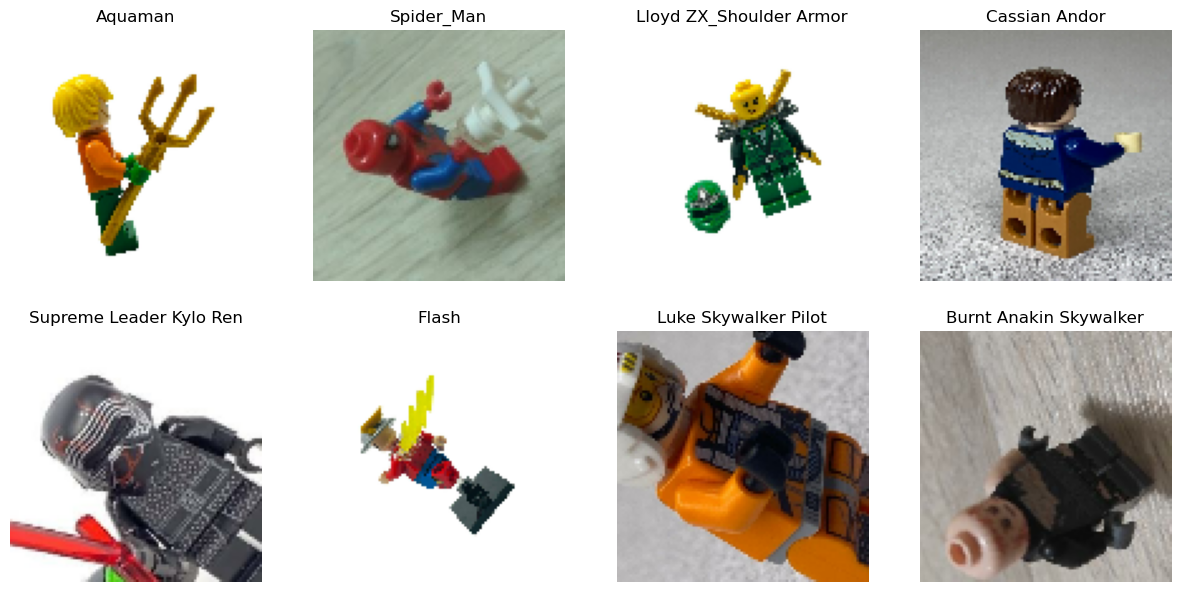

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 396

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 100, 100, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 98, 98, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (128, 49, 49, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (128, 47, 47, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (128, 23, 23, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (128, 21, 21, 64)        

In [17]:
model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics='accuracy')

In [18]:
early_stopping = keras.callbacks.EarlyStopping(
  monitor="val_loss",
   patience=5,
   verbose=1
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping],
    verbose=1,
    epochs=20
)

Epoch 1/20


296/296 [==============================] - 172s 302ms/step - loss: 4.6047 - accuracy: 0.0905 - val_loss: 3.3249 - val_accuracy: 0.2086
Epoch 2/20
296/296 [==============================] - 50s 169ms/step - loss: 2.4025 - accuracy: 0.3752 - val_loss: 1.7456 - val_accuracy: 0.5201
Epoch 3/20
296/296 [==============================] - 48s 161ms/step - loss: 1.4190 - accuracy: 0.6035 - val_loss: 1.2269 - val_accuracy: 0.6436
Epoch 4/20
296/296 [==============================] - 48s 161ms/step - loss: 1.0057 - accuracy: 0.7102 - val_loss: 0.9565 - val_accuracy: 0.7255
Epoch 5/20
296/296 [==============================] - 48s 161ms/step - loss: 0.7591 - accuracy: 0.7785 - val_loss: 0.8209 - val_accuracy: 0.7637
Epoch 6/20
296/296 [==============================] - 48s 161ms/step - loss: 0.5991 - accuracy: 0.8234 - val_loss: 0.7780 - val_accuracy: 0.7698
Epoch 7/20
296/296 [==============================] - 49s 167ms/step - loss: 0.5208 - accuracy: 0.8463 - val_loss: 1.0373 - val

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

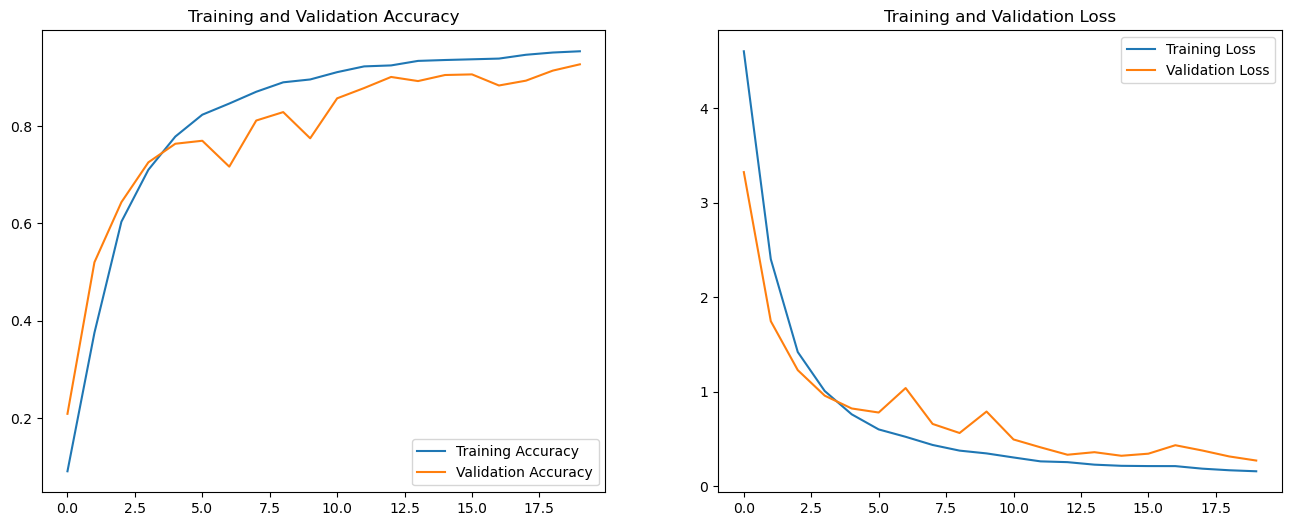

In [20]:
EPOCHS=20

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 43s 53ms/step - loss: 0.3145 - accuracy: 0.9102


first image to predict
actual label: Cyborg
4/4 [==============================] - 1s 26ms/step
predicted label: Cyborg


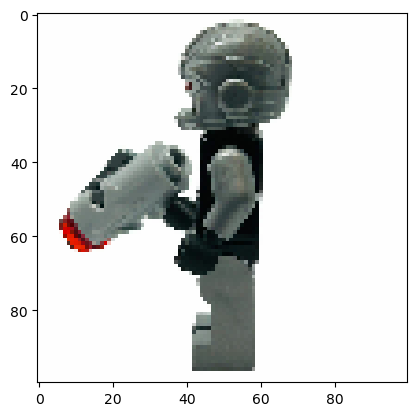

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


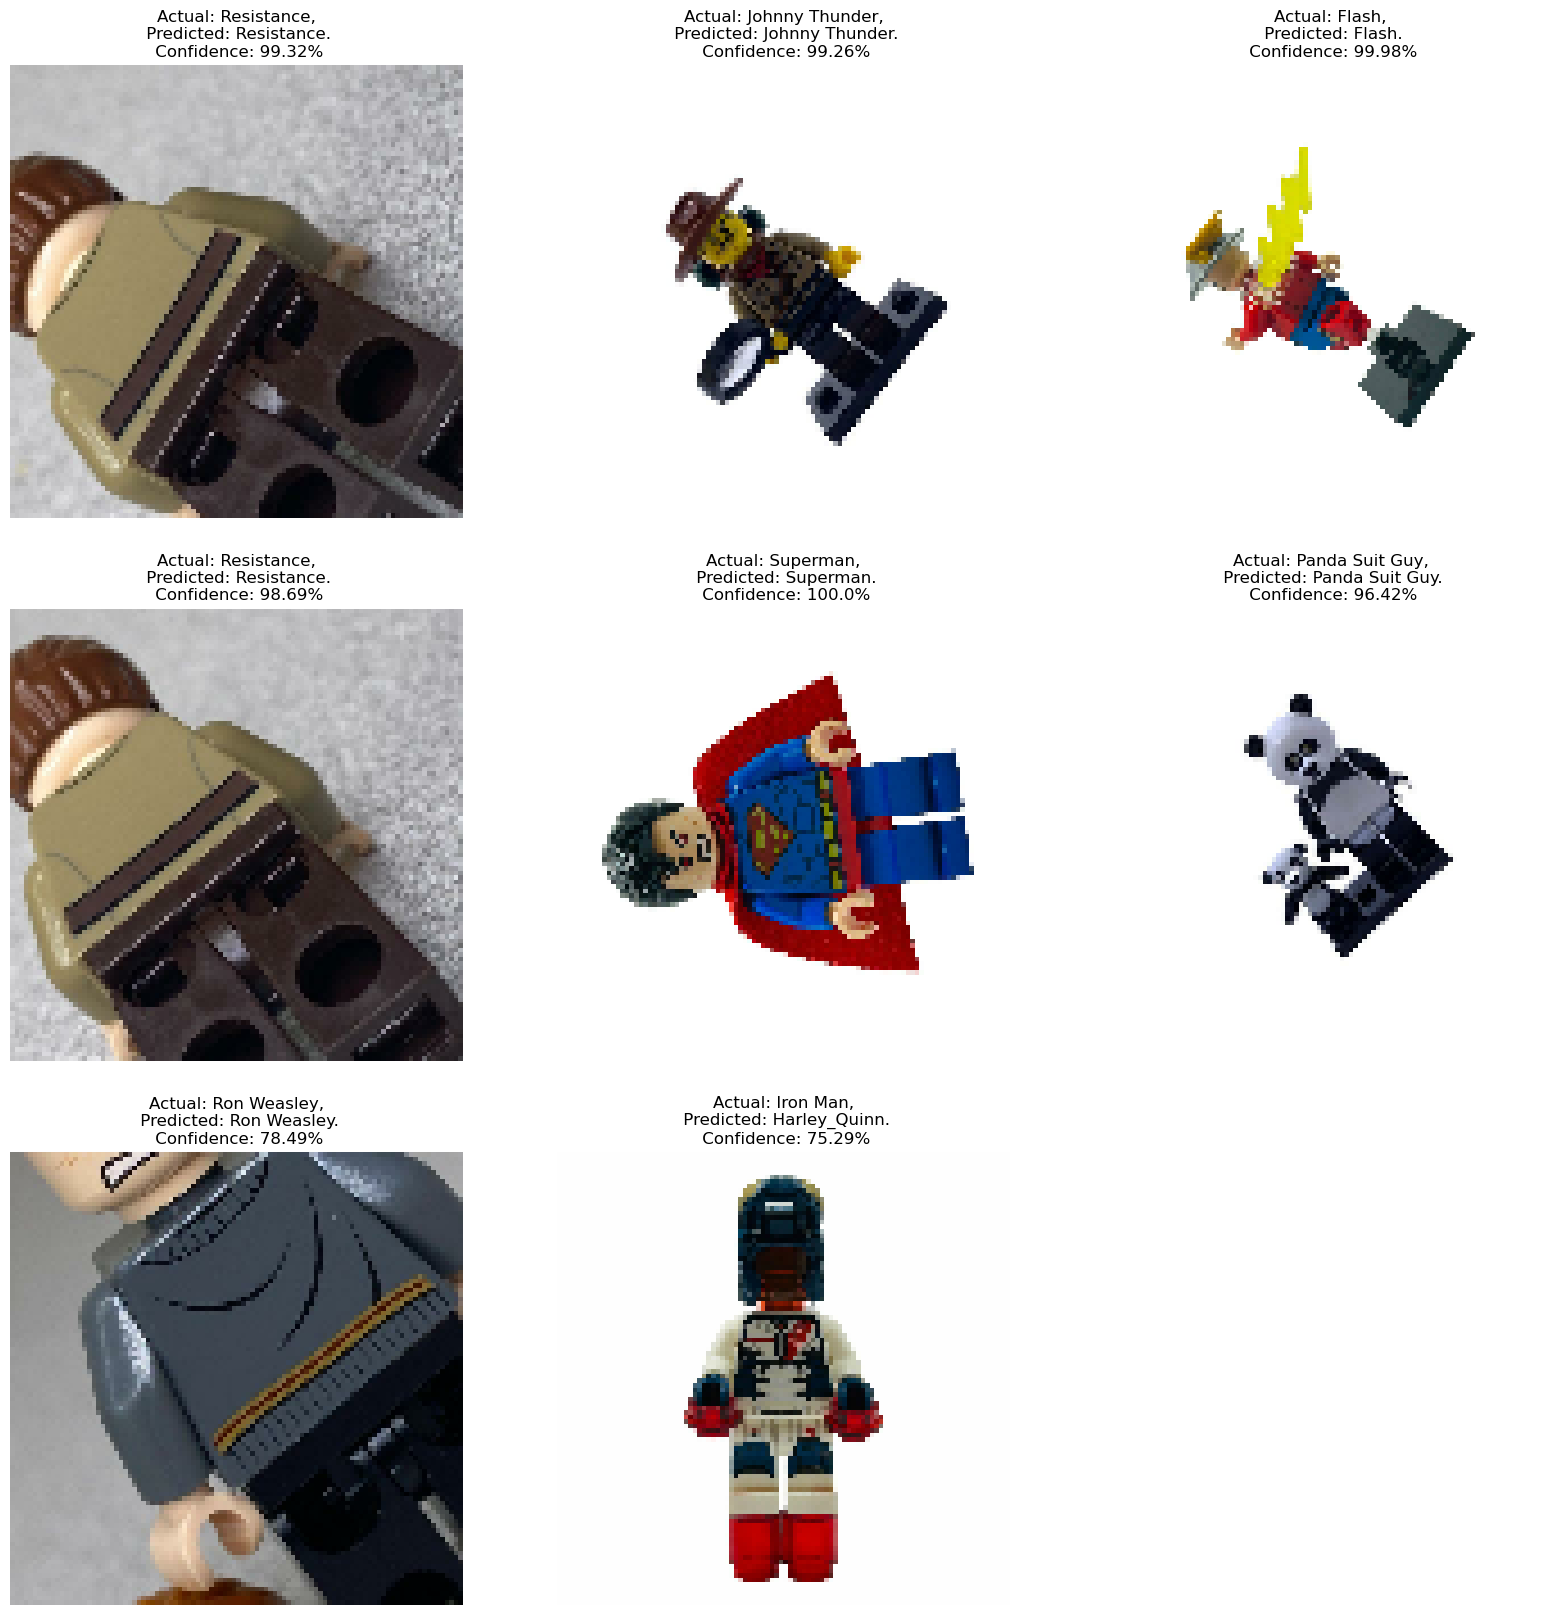

In [24]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [25]:
model_version="Mini396"
model.save(f"./Models/{model_version}")

INFO:tensorflow:Assets written to: ./Models/Mini396\assets


INFO:tensorflow:Assets written to: ./Models/Mini396\assets


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [27]:
predictions = model.predict(test_ds)
y_true = []
y_pred = []

# 将测试集中的真实标签和预测结果收集起来
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(model.predict(images), axis=1).numpy())

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
cm = conf_matrix

4/4 [==============================] - 0s 21ms/step


In [28]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [30]:
# Calculate class-wise accuracy
class_accuracy = {}
for i in range(n_classes):
    true_positive = conf_matrix[i][i] if i < conf_matrix.shape[0] else 0
    total_predicted = sum(conf_matrix[i]) if i < conf_matrix.shape[0] else 0
    
    # Avoid division by zero
    if total_predicted != 0:
        class_accuracy[class_names[i]] = true_positive / total_predicted
    else:
        class_accuracy[class_names[i]] = 0  # Set accuracy to 0 for classes with no predictions

# Print class-wise accuracies
for class_name, accuracy in class_accuracy.items():
    print(f'Class: {class_name}, Accuracy: {accuracy}')

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred,pos_label='pos_label',average='weighted')
overall_recall = recall_score(y_true, y_pred,pos_label='pos_label',average='weighted')
overall_f1 = f1_score(y_true, y_pred,pos_label='pos_label',average='weighted')
print(f'Overall Accuracy: {overall_accuracy}')
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1: {overall_f1}')


Class: ATST Raider from The Mandalorian, Accuracy: 1.0
Class: Admiral_Ackbar, Accuracy: 1.0
Class: Agent_13_Sharon_Carter, Accuracy: 0.5714285714285714
Class: Agent_Jack, Accuracy: 1.0
Class: Albus Dumbledore, Accuracy: 0.9444444444444444
Class: Aldrich_Killian, Accuracy: 1.0
Class: Alien_Avenger, Accuracy: 0.5714285714285714
Class: Alligator, Accuracy: 1.0
Class: Anna, Accuracy: 1.0
Class: Aplek Knights of Ren, Accuracy: 0.125
Class: Aquaman, Accuracy: 1.0
Class: Aragorn Lord of the Rings, Accuracy: 1.0
Class: Astronaut, Accuracy: 1.0
Class: Aunt May, Accuracy: 1.0
Class: Avengers_Age_of_Ultron_MK1, Accuracy: 1.0
Class: Ayesha, Accuracy: 1.0
Class: Baby Groot, Accuracy: 1.0
Class: Bane, Accuracy: 0.75
Class: Banshee_Lego_Collectible_Minifigure, Accuracy: 1.0
Class: Batgirl, Accuracy: 0.9615384615384616
Class: Batman, Accuracy: 0.125
Class: Battle_Dwarf, Accuracy: 1.0
Class: Battle_Mech, Accuracy: 1.0
Class: Batzarro, Accuracy: 1.0
Class: Benny, Accuracy: 1.0
Class: Black Anglerfish, A

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignor

In [31]:
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred,pos_label='pos_label',average='weighted')
overall_recall = recall_score(y_true, y_pred,pos_label='pos_label',average='weighted')
overall_f1 = f1_score(y_true, y_pred,pos_label='pos_label',average='weighted')
print(f'Overall Accuracy: {overall_accuracy}')
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1: {overall_f1}')

Overall Accuracy: 0.91015625
Overall Precision: 0.9296883422279523
Overall Recall: 0.91015625
Overall F1: 0.9092212338494421


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignor